In [2]:
image_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
target_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
color_target_path = "/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

In [3]:
import pandas as pd
dir_csv = "/kaggle/input/semantic-drone-dataset/class_dict_seg.csv"

df = pd.read_csv(dir_csv)
df.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [4]:
def create_dataset(image_path,target_path):
    dict_path = {"images":[],"masks":[]}
    for dir_name , _ , filenames in os.walk(image_path):
        for file in filenames:
            name = file.split(".")[0]
            dict_path["images"].append(f"{image_path}/{name}.jpg")
            dict_path["masks"].append(f"{target_path}/{name}.png")
    dataframe = pd.DataFrame(data=dict_path,index=np.arange(0,len(dict_path["images"])))
    return dataframe

In [5]:
def imshowimages(dataframe, num=3, bool_t=True):
    for i in range(int(num)):
        images, masks = dataframe.iloc[i]
        image = Image.open(images)
        mask = Image.open(masks)
        
        print(f"image shape:{np.asarray(image).shape}")
        print(f"mask shape:{np.asarray(mask).shape}")
        
        # Plot the image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        
        # Plot the mask if bool_t is True
        if bool_t:
            plt.figure(figsize=(8, 6))
            plt.imshow(mask)
        
        text = "with" if bool_t else "without"
        plt.title(f"Image {text} mask")
        plt.show()

In [6]:
import os
import numpy as np
df = create_dataset(image_path,target_path)

image shape:(4000, 6000, 3)
mask shape:(4000, 6000)


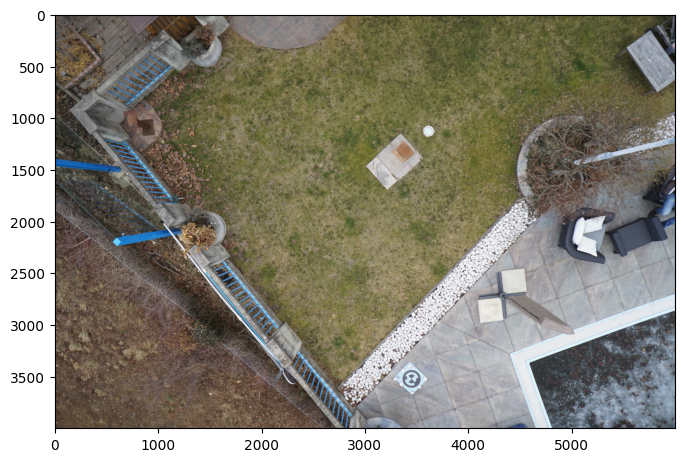

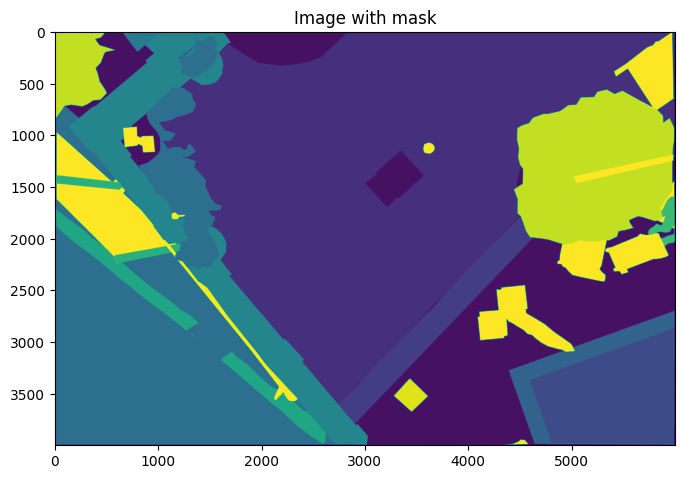

image shape:(4000, 6000, 3)
mask shape:(4000, 6000)


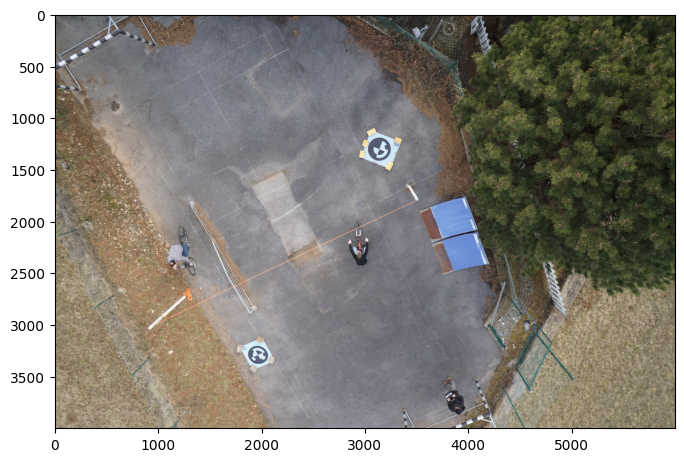

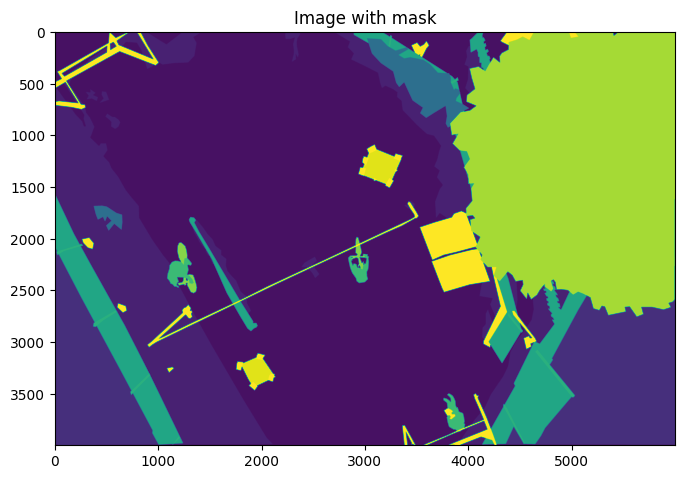

image shape:(4000, 6000, 3)
mask shape:(4000, 6000)


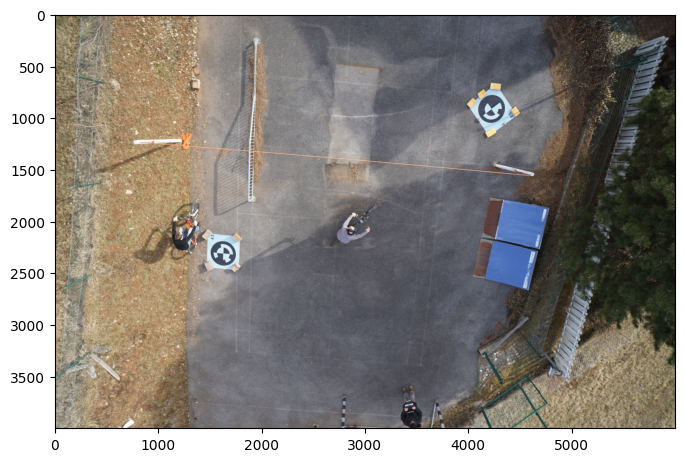

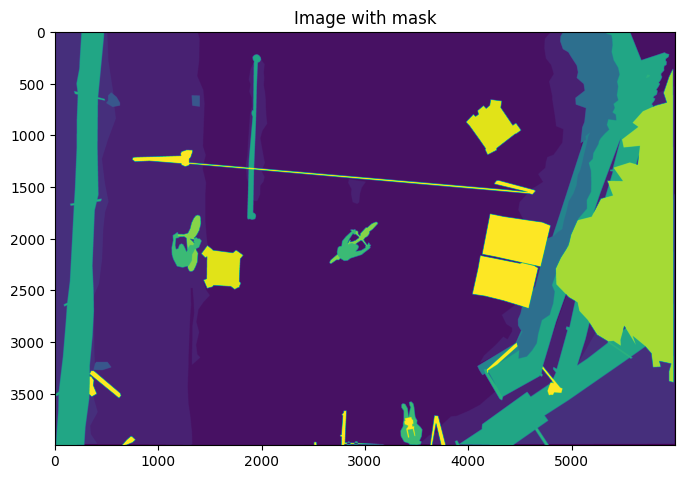

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
imshowimages(df)

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class transformpipeline:
    def __init__(self, height, width, damage, weather, cut, spatial):
        self.height = height
        self.width = width
        self.damage = damage
        self.weather = weather
        self.cut = cut
        self.spatial = spatial
        self._damage_transform = None
        self._weather_transform = None
        self._cut_transform = None
        self._spatial_transform = None
        self._base_transform = None
        
        self._setup_transform()

    def _setup_transform(self):
        if self.damage:
            self._damage_transform = A.Compose([
                A.Defocus(0.1),
                A.PixelDropout(p=0.1)
            ])
        if self.weather:
            self._weather_transform = A.Compose([
                A.RandomRain(p=0.1),
                A.RandomSnow(p=0.1)
            ])
        if self.cut == 1:
            self._cut_transform = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.15)
            ])
        elif self.cut == 2:
            self._cut_transform = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.10),
                A.RandomCrop(width=1283, height=2000, p=0.05)
            ])
        elif self.cut > 2:
            self._cut_transform = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.15),
                A.RandomCrop(width=1283, height=2000, p=0.10),
                A.RandomCrop(width=855, height=1333, p=0.05)
            ])
        if self.spatial:
            self._spatial_transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Affine(rotate=[-15, 15], p=0.35),
                A.Perspective(scale=(0.05, 0.25), p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5)
            ])
        self._base_transform = A.Compose([
            A.Resize(height=self.height, width=self.width),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __call__(self, image: np.array, mask: np.array, debug_mode: bool = False):
        if self._weather_transform:
            transformed = self._weather_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        if self._damage_transform:
            transformed = self._damage_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        if self._cut_transform:
            transformed = self._cut_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        if self._spatial_transform:
            transformed = self._spatial_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        transformed = self._base_transform(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]
        return {"image": image, "mask": mask}


In [9]:
import os
import numpy as np
from PIL import Image

class datasetforseg:
    def __init__(self, image_dir, mask_dir, transform=None, image_ext=".jpg", mask_ext=".png"):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_file_names = [f.replace(image_ext, "") for f in os.listdir(self.image_dir)]
        self.image_ext = image_ext
        self.mask_ext = mask_ext

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_name = self.image_file_names[idx]
        image_path = os.path.join(self.image_dir, image_name + self.image_ext)
        mask_path = os.path.join(self.mask_dir, image_name + self.mask_ext)
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        image = np.array(image)
        mask = np.array(mask)
        
        
        # Normalize mask values to binary if needed
        mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))  # Min-Max normalization
        mask[mask > 0.5] = 1  # Convert to binary
        mask[mask <= 0.5] = 0
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        
        return image, mask


In [10]:
transformpipelineinstance = transformpipeline(height=704,width=1056,damage=True,weather=True,cut=1,spatial=True)
dataset = datasetforseg(image_dir=image_path,mask_dir=target_path,transform=transformpipelineinstance)

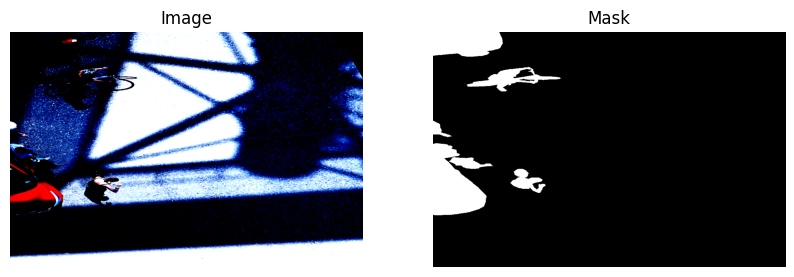

In [11]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure you import NumPy

# Assuming the dataset returns the image in (C, H, W) format
image, mask = dataset[10]  # Get the 11th sample (index 10)

# Check if image is a NumPy array, if not convert it
if not isinstance(image, np.ndarray):
    image = np.array(image)

# Transpose the image to (H, W, C)
image = image.transpose(1, 2, 0)

# Ensure the mask is also a NumPy array
if not isinstance(mask, np.ndarray):
    mask = np.array(mask)

# Plot the image and mask
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

# Show the plot
plt.show()

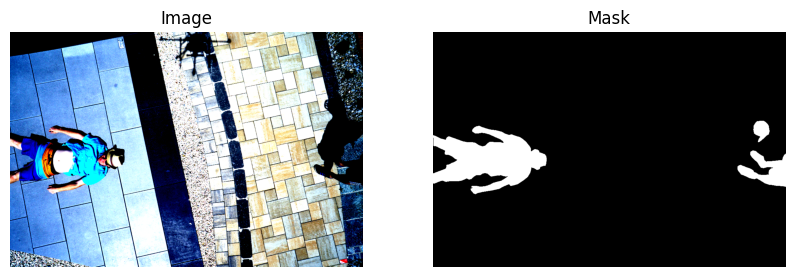

In [12]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure you import NumPy

# Assuming the dataset returns the image in (C, H, W) format
image, mask = dataset[145]  # Get the 11th sample (index 10)

# Check if image is a NumPy array, if not convert it
if not isinstance(image, np.ndarray):
    image = np.array(image)

# Transpose the image to (H, W, C)
image = image.transpose(1, 2, 0)

# Ensure the mask is also a NumPy array
if not isinstance(mask, np.ndarray):
    mask = np.array(mask)

# Plot the image and mask
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

# Show the plot
plt.show()

In [13]:
from torch.utils.data import random_split , Subset , DataLoader
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_dataset , test_dataset = random_split(dataset,[train_size,test_size])

In [14]:
train_subset_size = int(0.8*len(train_dataset))
test_subset_size = int(0.8*len(test_dataset))

train_subset = Subset(train_dataset,range(train_subset_size))
test_subset = Subset(test_dataset,range(test_subset_size))

In [15]:
len(train_subset)

256

In [16]:
train_dataloader = DataLoader(train_subset,batch_size=1,shuffle=True)
test_dataloader = DataLoader(test_subset,batch_size=1,shuffle=True)

In [17]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 23.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=baf3ee3816acb1c0cb20f6f5fd4fed2bf1cd36b8032de5542f363382d7422806
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9712ff30994f60eaff272990c33e2635c8e657bcfe52e4a1201dc9165da9afa1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [49]:
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Define the model

# Define a more complex model with additional modifications
model = smp.Unet(
    encoder_name="resnet101",            # Use a deeper ResNet backbone
    encoder_weights="imagenet",           # Pre-trained weights
    in_channels=3,                        # Input channels
    classes=1,                            # Number of output classes
    decoder_attention_type='scse',        # Add attention mechanism (Squeeze-and-Excitation + Convolutional Spatial Attention)
                      
).to(device).half()
# Convert model to half precision


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=config.lr)


accumulation_steps = 4  # Adjust as needed

def accuracy(pred, target):
    correct = (pred == target).float()
    return correct.sum() / correct.numel()  # Calculate overall accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0  # Initialize training accuracy
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for i, (images, masks) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            images = images.to(device).half()  # Convert images to half precision
            masks = masks.to(device).half()  # Convert masks to half precision
            
            optimizer.zero_grad()
            
            outputs = model(images)  # Ensure this outputs [batch_size, num_classes, height, width]
            outputs = outputs.squeeze(1)  # Only if necessary (check your model output shape)
            
            loss = loss_function(outputs, masks)
            if torch.isnan(loss) or torch.isinf(loss):
                print("Loss is NaN or Inf. Skipping this batch.")
                continue
            
            loss = loss / accumulation_steps  # Scale the loss
            loss.backward()  # Backpropagation
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()  # Update weights
            
            train_loss += loss.item()
            
            # Convert outputs to class predictions
            preds = torch.sigmoid(outputs) > 0.5  # Apply threshold for binary classification
            preds = preds.long()  # Convert boolean to long for accuracy calculation
            
            # Calculate overall accuracy for the current batch
            batch_accuracy = accuracy(preds, masks).item()
            train_accuracy += batch_accuracy
            
            # Update progress bar with current loss and accuracy
            tepoch.set_postfix(loss=loss.item(), accuracy=batch_accuracy)
    
    train_avg_loss = train_loss / len(train_dataloader)
    train_avg_accuracy = train_accuracy / len(train_dataloader)  # Average accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_avg_loss:.4f}, Accuracy: {train_avg_accuracy:.4f}')
    
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0  # Initialize validation accuracy
    
    with torch.no_grad():
        for images, masks in test_dataloader:
            images = images.to(device).half()  # Convert images to half precision
            masks = masks.to(device).half()  # Convert masks to half precision
            
            outputs = model(images).squeeze(1)
            loss = loss_function(outputs, masks)
            val_loss += loss.item()
            
            # Convert outputs to class predictions
            preds = torch.sigmoid(outputs) > 0.5  # Apply threshold for binary classification
            preds = preds.long()  # Convert boolean to long for accuracy calculation
            
            # Calculate overall accuracy for the validation set
            val_accuracy += accuracy(preds, masks).item()
    
    val_avg_loss = val_loss / len(test_dataloader)
    val_avg_accuracy = val_accuracy / len(test_dataloader)  # Average accuracy
    print(f'Validation Loss: {val_avg_loss:.4f}, Accuracy: {val_avg_accuracy:.4f}')

Epoch 1/10: 100%|██████████| 256/256 [09:10<00:00,  2.15s/batch, accuracy=0.98, loss=0.0675] 


Epoch [1/10], Loss: 0.1121, Accuracy: 0.8902
Validation Loss: 0.4709, Accuracy: 0.8991


Epoch 2/10: 100%|██████████| 256/256 [09:23<00:00,  2.20s/batch, accuracy=0.926, loss=0.115] 


Epoch [2/10], Loss: 0.1136, Accuracy: 0.8873
Validation Loss: 0.5331, Accuracy: 0.9034


Epoch 3/10: 100%|██████████| 256/256 [09:00<00:00,  2.11s/batch, accuracy=0.881, loss=0.12]  


Epoch [3/10], Loss: 0.1143, Accuracy: 0.8846
Validation Loss: 0.4434, Accuracy: 0.9052


Epoch 4/10: 100%|██████████| 256/256 [08:58<00:00,  2.10s/batch, accuracy=0.882, loss=0.113] 


Epoch [4/10], Loss: 0.1119, Accuracy: 0.8905
Validation Loss: 0.7995, Accuracy: 0.8999


Epoch 5/10: 100%|██████████| 256/256 [08:51<00:00,  2.08s/batch, accuracy=0.798, loss=0.152] 


Epoch [5/10], Loss: 0.1128, Accuracy: 0.8884
Validation Loss: 0.4521, Accuracy: 0.9021


Epoch 6/10: 100%|██████████| 256/256 [09:03<00:00,  2.12s/batch, accuracy=0.946, loss=0.0831]


Epoch [6/10], Loss: 0.1147, Accuracy: 0.8862


Epoch 7/10: 100%|██████████| 256/256 [08:40<00:00,  2.03s/batch, accuracy=0.867, loss=0.12]  


Epoch [7/10], Loss: 0.1115, Accuracy: 0.8913
Validation Loss: 0.5018, Accuracy: 0.9027


Epoch 8/10: 100%|██████████| 256/256 [08:38<00:00,  2.03s/batch, accuracy=0.896, loss=0.117] 


Epoch [8/10], Loss: 0.1139, Accuracy: 0.8853
Validation Loss: 0.4433, Accuracy: 0.9004


Epoch 9/10: 100%|██████████| 256/256 [08:55<00:00,  2.09s/batch, accuracy=0.847, loss=0.129] 


Epoch [9/10], Loss: 0.1144, Accuracy: 0.8850
Validation Loss: 0.6767, Accuracy: 0.9039


Epoch 10/10: 100%|██████████| 256/256 [08:49<00:00,  2.07s/batch, accuracy=0.951, loss=0.0892]


Epoch [10/10], Loss: 0.1147, Accuracy: 0.8821
Validation Loss: 0.4378, Accuracy: 0.9054
